In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom_test    # binomial檢定
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']  # 設定中文字形, 沒有安裝就註解掉

matplotlib[中文字形安裝](https://pyecontech.com/2020/03/27/python%E6%95%99%E5%AD%B8-%E5%A6%82%E4%BD%95%E8%A7%A3%E6%B1%BAmatplotlib%E4%B8%AD%E6%96%87%E4%BA%82%E7%A2%BC%E5%95%8F%E9%A1%8C/)

下面三個函數取自 stackoverflow 上這篇[剪去分類樹上無用分支](https://stackoverflow.com/questions/51397109/prune-unnecessary-leaves-in-sklearn-decisiontreeclassifier)，方便決策樹視覺化.

In [2]:
def is_leaf(tr, index):
    left = tr.children_left[index]
    right = tr.children_right[index]
    return (left == -1) and (right == -1)

def prune_index(tr, decisions, index=0):
    left = tr.children_left[index]
    right = tr.children_right[index]
    
    # 先讓子節點化簡.
    if not is_leaf(tr, left):
        prune_index(tr, decisions, left)
    if not is_leaf(tr, right):
        prune_index(tr, decisions, right)

    # 如果兩個子節點都是葉節點, 而且預測相同結果, 則取消這個 split
    if is_leaf(tr, left) and is_leaf(tr, right) and (decisions[right] == decisions[left]):
        tr.children_left[index] = -1
        tr.children_right[index] = -1

def prune_duplicate_leaves(mdl):
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # 每個節點上數量多的一方
    prune_index(mdl.tree_, decisions, 0)

In [3]:
df = pd.read_csv('data/feature_interview.csv')
y = pd.read_csv('data/interview_data.csv').is_ad.map({'N': 0, 'Y': 1})
df.columns

Index(['len', '群', 'line', '1{5,}', 'ㄕㄊ', 'ㄐㄨ?ㄌ', 'ㄑㄗ', 'ㄊㄌ', '\(1{3,4}\)'], dtype='object')

# 決策樹預測

比較過用或不用`length`作為特徵，發現加入比較好。

比較過樹的深度 4~9層，7層之後增加幅度減小所以選用7層。

In [4]:
X, X_test, y_tr, y_test = train_test_split(df, y,
                                              test_size=0.2,
                                              stratify=y,
                                              random_state=88)

In [5]:
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=20,
                              max_depth=7
                             )
tree.fit(X, y_tr)
tree.score(X, y_tr)

0.9873333333333333

# 剪去無用的決策&視覺化

剪去多餘的分支之後發現，除了`長度`在 12~57 之間的訊息，需要較多規則。

### 觀察

可以發現長出來的樹只有少部分節點較深(需要較多規則)，大部分在 4~5 層內就已經分好了，可以考慮用 leaf-wise 生長的樹(如 lightGBM)學習。

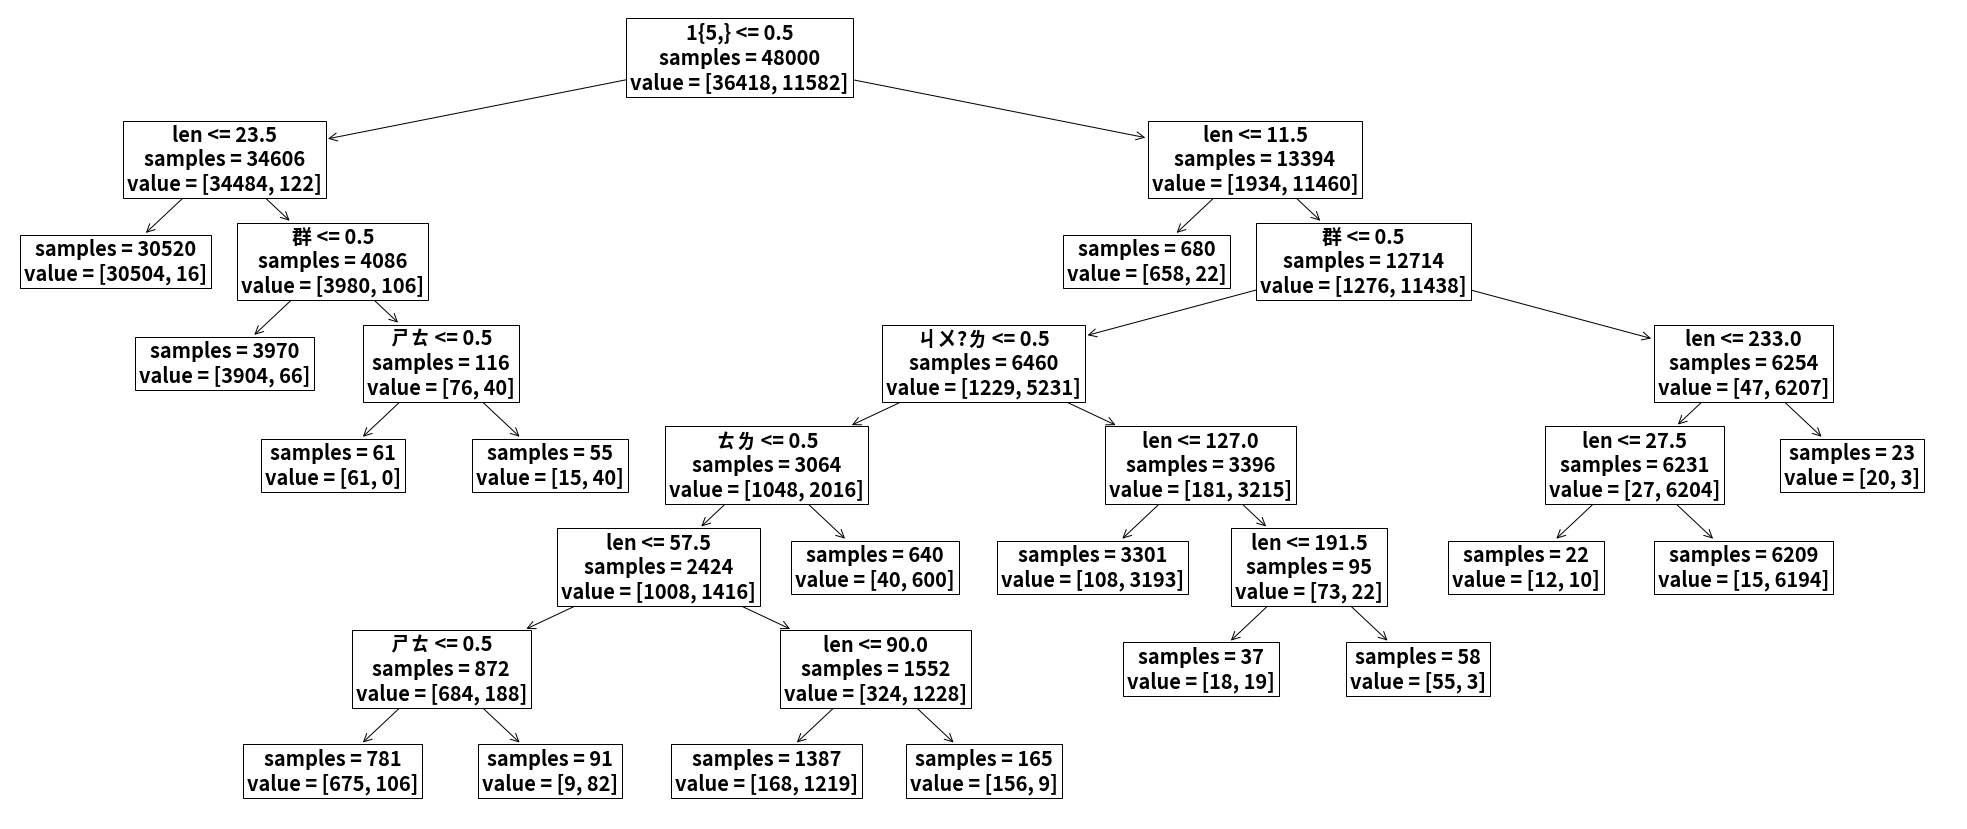

In [6]:
prune_duplicate_leaves(tree)

plt.figure(figsize=(35, 15))
plot_tree(tree, fontsize=20, impurity=False, 
          feature_names=df.columns.to_list() # 如果沒有安裝中文就註解
         )
None

# 驗證樹的預測

一般做法可能會切 k-fold 的驗證集(validation set)，驗證樹產生的預測或是樹的結構穩不穩定，然後計算交叉熵。

在這個例子中只有 `長度` 這個特徵不是 boolean 的，因此樹的結構很固定。所以我只考慮了剪枝。

一個節點如果有 `10廣告`, `9非廣告`，根據決策樹的規則；會全部預測為廣告。
但是這個預測可能不是好的，因為如果拿另一組資料(validation set)經過相同決策過程，驗證集中該節點結果可能相反。
剪枝正是要回答這個問題---**`這個節點夠不夠好?`**。

透過驗證集，我們 **`有機會`** 把比例不夠懸殊的節點移除。但這裡我採用我認為更好的方法---
[假設檢定](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)
中的 [binomial test](https://en.wikipedia.org/wiki/Binomial_test)。

## 假設假定

假設檢定適統計模型中常見的模型選擇方法(藉由檢定某參數是否為0)。

用假設檢定的好處是：

* 用了**全部的訓練集**來決定這個節點的預測合不合理

* 不靠**隨機產生的驗證集**來決定，且通常驗證集遠比訓練集小，隨機性大

binomail test 是用來檢定這個節點是`廣告的機率`和`不是廣告的機率`是不是相等。如果不是、表示機率`顯著的`偏向某一方，因此用較多的一方預測是合理的。

可以看到樣本數過於接近的葉節點 (18, 19)、(12, 10) 被切除。

[18 19] accept pa == pb, Cut leaf.
[12 10] accept pa == pb, Cut leaf.


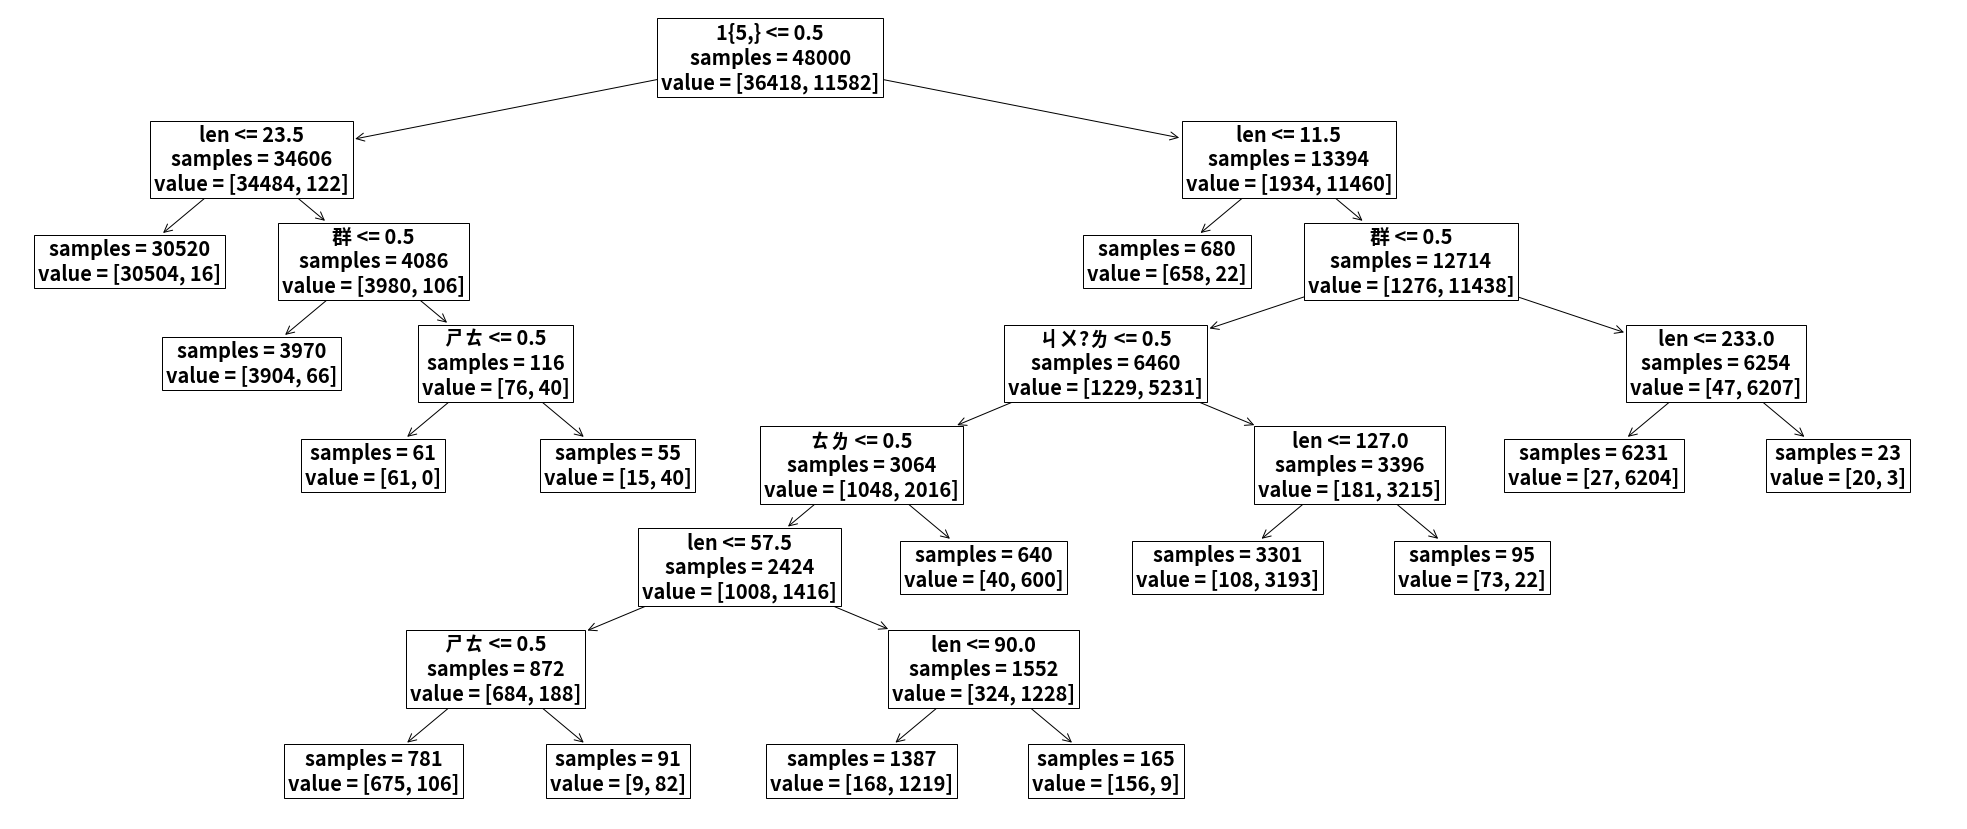

In [7]:
values = np.array(tree.tree_.value, dtype=np.int)[:, 0, :]  # 各節點的正負樣本數
level = 0.01  # 顯著水準

def travel(tr, node):
    
    for brach in (tr.children_left, tr.children_right):
        i = brach[node]          # 取該點的 左/右 子節點
        if is_leaf(tr, i):
            val = values[i]      # 取子葉的正負樣本數量
            p = binom_test( val, alternative='two-sided')  
            if p > level:        # p > 顯著水準 表示不顯著
                print(f'{val} accept pa == pb, Cut leaf.')
                brach[node] = -1  # 取消該分支, 預測值由父節點決定
        else:
            travel(tr, i)

travel(tree.tree_, 0)

plt.figure(figsize=(35, 15))
plot_tree(tree, fontsize=20, impurity=False, 
          feature_names=X.columns.to_list() # 如果沒有安裝中文就註解
         )
None

# 在test 上的表現

test準確率 0.9871 ~= train準確率 0.9873，可見並沒有發生 overfitting.

In [8]:
pred = tree.predict(X_test)
confusion = (pred * 2 + y_test).value_counts().sort_index()
print("""
     \     Is AD
      \   N     Y
       o-----+-----o
     0 |{0:5d}|{1:5d}|
 pred  +-----+-----+
     1 |{2:5d}|{3:5d}|
       o-----+-----o  """.format(*confusion.values) 
     )
print(f'Accuracy: {tree.score(X_test, y_test):.4f}')
print(f'Precision: {confusion[3] / pred.sum():.4f}')
print(f'Recall: {confusion[3] / y_test.sum():.4f}')


     \     Is AD
      \   N     Y
       o-----+-----o
     0 | 9008|   58|
 pred  +-----+-----+
     1 |   97| 2837|
       o-----+-----o  
Accuracy: 0.9871
Precision: 0.9669
Recall: 0.9800


# 全部加入訓練&預測

sklearn 的 tree 好像不能輸出成 model 檔案。如果要預測，在這裡讀取feature檔(執行 preprocessing.py 得到)並預測。

In [9]:
tree.fit(df, y)
# newdata = pd.read_csv('data/feature_ooxx.csv')
# ans = pd.DataFrame(tree.predict(newdata))
# ans.to_csv('answer.csv')

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20)